In [1]:
import random
from tqdm import trange

import pygame
import matplotlib.pyplot as plt

import numpy as np

from RushHour4.core import Map, Environment
from RushHour4.interact import Game, visualize, load_image_objects

pygame 2.3.0 (SDL 2.24.2, Python 3.10.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
ROWS, COLS = 10, 10
EPISODES = 1_0_000
MOVE_PENALTY = 1
COLLISION_PENALTY = 100
CATCH_REWARD = 200
STEPS = 400

EPSILON = 1.0
EPS_DECAY = 0.99996
LEARNING_RATE = 0.1
DISCOUNT = 0.95

SHOW = False
SHOW_EVERY = 10000

if SHOW:
    blockSize = 50
    global screen, CLOCK
    agent, action = None, None
    pygame.init()
    screen = pygame.display.set_mode((blockSize * COLS, blockSize * ROWS))
    clock = pygame.time.Clock()
    screen.fill((0, 0, 0))
    pyimage_objects = load_image_objects()

mymap = Map(ROWS, COLS)
game = Game(mymap, 50)

start_q_table = None # None or Filename
# start_q_table = 'Models/two_common_qtable_new.pickle' # None or Filename

if start_q_table is None:
    # initialize the q-table#
    q_table = np.zeros((ROWS*COLS, ROWS*COLS, ROWS*COLS, 4))
    for primary_cop_pos in range(game._start, game._end + 1):
        for secondary_cop_pos in range(game._start, game._end + 1):
            for thief_pos in range(game._start, game._end + 1):
                    q_table[primary_cop_pos, secondary_cop_pos, thief_pos, :] = [np.random.uniform(-1, 1) for i in range(4)]

else:
    with open(start_q_table, 'rb') as f:
        q_table = pickle.load(f)
         
action_direction = ['up', 'down', 'left', 'right']


In [3]:
def get_random_pos():
    possible_start_locations = game.valid_states
    return random.choice(possible_start_locations)

def get_cop_states(cop1_pos, cop2_pos, thief_pos):
    cop1_state = [cop1_pos, cop2_pos, thief_pos]
    cop2_state = [cop2_pos, cop1_pos, thief_pos]
    return cop1_state, cop2_state

def perform_action(observations):
    if np.random.random() > EPSILON:
        direction = np.argmax(q_table[observations[0]][observations[1]][observations[2]])
    else:
        direction = np.random.randint(0, 4)
    return direction

def update_table(reward, old_state, new_state, direction):
    max_future_q = np.max(q_table[new_state[0]][new_state[1]][new_state[2]])
    current_q = q_table[old_state[0]][old_state[1]][old_state[2]][direction]
    
    if reward == CATCH_REWARD*2:
        new_q = CATCH_REWARD
    else:
        new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
    q_table[old_state[0]][old_state[1]][old_state[2]][direction] = new_q

Total Steps: 800: 100%|██████████| 10000/10000 [03:05<00:00, 53.82it/s]


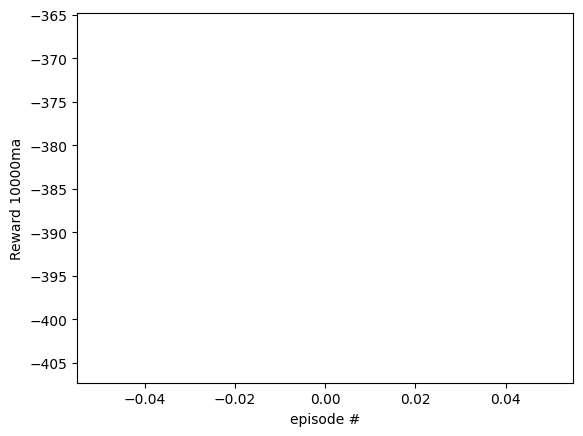

Catching Percentage : Cop 1 : 40.0
Catching Percentage : Cop 2 : 60.0
Catching Percentage : Total : 2.45
Average Steps To Catch      : 786.0421


In [4]:
episode_rewards = []
catch_count1 = 0
catch_count2 = 0

progress = trange(EPISODES)
for episode in progress:

    game.initialize()
    game.setup_agents({'1': game.random_state()})
    game.setup_agents({'2': game.random_state()})
    game.setup_agents({'x': game.random_state()})

    episode_reward = 0
    cop1_caught = 0
    cop2_caught = 0

    cop1_pos = game.locate_agent('1')
    cop2_pos = game.locate_agent('2')
    thief_pos = game.locate_agent('x')
    cop1_state, cop2_state = get_cop_states(cop1_pos, cop2_pos, thief_pos)

    for i in range(STEPS):
        cop1_direction = perform_action(cop1_state)
        cop2_direction = perform_action(cop2_state)
        if action_direction[cop1_direction] in game.valid_actions(cop1_pos, index=True):
            game.update({'1': action_direction[cop1_direction]})
        
        if action_direction[cop2_direction] in game.valid_actions(cop2_pos, index=True):
            game.update({'2': action_direction[cop2_direction]})

        if game._agent_location['1'] == game._agent_location['x']:
            reward = CATCH_REWARD
            cop1_caught = CATCH_REWARD
            catch_count1 += 1
        elif game._agent_location['2'] == game._agent_location['x']:
            reward = CATCH_REWARD
            cop2_caught = CATCH_REWARD
            catch_count2 += 1
        else:
            reward = -MOVE_PENALTY
        
        if SHOW:
            visualize(screen, game.grid, pyimage_objects, ROWS, COLS, blockSize)
            pygame.display.update()
            time.sleep(1)

        cop1_pos = game.locate_agent('1')
        cop2_pos = game.locate_agent('2')
        
        if reward != CATCH_REWARD:
            thief_run_direction = game.thief_run()
            if thief_run_direction in game.valid_actions(thief_pos, index=True):
                game.update({'x': thief_run_direction})

        thief_pos = game.locate_agent('x')
        cop1_state_new, cop2_state_new = get_cop_states(cop1_pos, cop2_pos, thief_pos)

        update_table(reward, cop1_state, cop1_state_new, cop1_direction)
        update_table(reward, cop2_state, cop2_state_new, cop1_direction)

        cop1_state, cop2_state = cop1_state_new, cop2_state_new

        episode_reward += reward
        if reward == CATCH_REWARD:
            break
    
    progress.set_description(f'Total Steps: {STEPS - episode_reward}')
    episode_rewards.append(episode_reward)
    EPSILON *= EPS_DECAY

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f'Reward {SHOW_EVERY}ma')
plt.xlabel('episode #')
plt.show()

catch_count_total = (catch_count1 + catch_count2)
print('Catching Percentage : Cop 1 :', catch_count1 * 100 / catch_count_total)
print('Catching Percentage : Cop 2 :', catch_count2 * 100 / catch_count_total)
print('Catching Percentage : Total :', catch_count_total * 100 / EPISODES)
print('Average Steps To Catch      :', STEPS - (sum(episode_rewards)/len(episode_rewards)))